In [17]:
import multiprocessing as mp
import time
import numpy as np
import pandas as pd

print("Number of processors: ", mp.cpu_count())

def runtime(func, obj, n_samples=10):
    samples = []
    for sample in range(n_samples):
        start = time.time()
        func(*obj)
        stop = time.time()
        samples.append(stop - start)
    return sum(samples)/n_samples

Number of processors:  8


In [18]:
from symred.symplectic import random_PauliwordOp
from symred.utils import random_symplectic_matrix

In [19]:
matrix = random_symplectic_matrix(100, 50000)
matrix

array([[1, 1, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 1]])

In [20]:
sort = np.lexsort(matrix.T)
matrix[sort]

array([[1, 0, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 1, 1, 1],
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [21]:
def qsort(inlist):
    if inlist == []: 
        return []
    else:
        pivot = inlist[0]
        lesser = qsort([x for x in inlist[1:] if x < pivot])
        greater = qsort([x for x in inlist[1:] if x >= pivot])
        return lesser + [pivot] + greater

In [22]:
listed = matrix.tolist()

%timeit qsort(listed)

231 ms ± 3.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%timeit
sort = np.lexsort(matrix.T)
matrix[sort]

277 ms ± 8.63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%timeit np.unique(matrix)

184 ms ± 2.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [181]:
from symred.symplectic import PauliwordOp

def multiplication(P,Q):
    symp_stack = []
    coeff_stack = []
    for symp_vec, coeff, Y_count_single in zip(Q.symp_matrix, Q.coeff_vec, Q.Y_count):
        # phaseless multiplication is binary addition in symplectic representation
        phaseless_prod = np.bitwise_xor(P.symp_matrix, symp_vec)
        symp_stack.append(phaseless_prod)
        
        # now have to correct the phases incurred from Pauli multiplication
        Y_count_out = np.einsum('ij->i', np.bitwise_and(*np.hsplit(phaseless_prod, 2)))
        # the full phase modification
        sign_change = (-1) ** np.einsum('ij->i', np.bitwise_and(P.X_block, np.hsplit(symp_vec,2)[1]))
        phase_mod = sign_change * (-1j) ** (P.Y_count + Y_count_single + 3*Y_count_out)
        coeff_vec = phase_mod * P.coeff_vec * coeff
        coeff_stack.append(coeff_vec)

    return PauliwordOp(np.vstack(symp_stack), np.hstack(coeff_stack)).cleanup()

In [207]:
n_q = 10
n_t = 10

def check_match(P,Q):
    return P*Q == multiplication(P,Q)

P = random_PauliwordOp(n_q, n_t)
Q = random_PauliwordOp(n_q, n_t)


vec = np.vectorize(check_match)

In [208]:
vec([1,1,1,1,1])

TypeError: check_match() takes 0 positional arguments but 1 was given

In [200]:
help(np.vectorize)

Help on class vectorize in module numpy:

class vectorize(builtins.object)
 |  vectorize(pyfunc, otypes=None, doc=None, excluded=None, cache=False, signature=None)
 |  
 |  vectorize(pyfunc, otypes=None, doc=None, excluded=None, cache=False,
 |            signature=None)
 |  
 |  Generalized function class.
 |  
 |  Define a vectorized function which takes a nested sequence of objects or
 |  numpy arrays as inputs and returns a single numpy array or a tuple of numpy
 |  arrays. The vectorized function evaluates `pyfunc` over successive tuples
 |  of the input arrays like the python map function, except it uses the
 |  broadcasting rules of numpy.
 |  
 |  The data type of the output of `vectorized` is determined by calling
 |  the function with the first element of the input.  This can be avoided
 |  by specifying the `otypes` argument.
 |  
 |  Parameters
 |  ----------
 |  pyfunc : callable
 |      A python function or method.
 |  otypes : str or list of dtypes, optional
 |      The 

In [160]:
from stim import PauliString, 

In [171]:
help(PauliString)

Help on class PauliString in module stim._stim_march_avx2:

class PauliString(pybind11_builtins.pybind11_object)
 |  A signed Pauli tensor product (e.g. "+X \u2297 X \u2297 X" or "-Y \u2297 Z".
 |  
 |  Represents a collection of Pauli operations (I, X, Y, Z) applied pairwise to a collection of qubits.
 |  
 |  Examples:
 |      >>> import stim
 |      >>> stim.PauliString("XX") * stim.PauliString("YY")
 |      stim.PauliString("-ZZ")
 |      >>> print(stim.PauliString(5))
 |      +_____
 |  
 |  Method resolution order:
 |      PauliString
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__(...)
 |      __add__(self: stim._stim_march_avx2.PauliString, rhs: stim._stim_march_avx2.PauliString) -> stim._stim_march_avx2.PauliString
 |      
 |      Returns the tensor product of two Pauli strings.
 |      
 |      Concatenates the Pauli strings and multiplies their signs.
 |      
 |      Args:
 |          rhs: A second stim.Paul

In [174]:
PauliString('XX_XY') + PauliString('YY')

stim.PauliString("+XX_XYYY")

In [158]:
Y_symp = []
Y_para = []
Y_open = []
Y_qisk = []

n_q = 10

for n_t in range(1, 100):
    print(n_t)
    P_symr = random_PauliwordOp(n_q, n_t)
    Q_symr = random_PauliwordOp(n_q, n_t)
    P_open = sum(P_symr.PauliwordOp_to_OF)
    Q_open = sum(Q_symr.PauliwordOp_to_OF)
    P_qisk = P_symr.to_PauliSumOp
    Q_qisk = Q_symr.to_PauliSumOp

    Y_symp.append(runtime(lambda x,y:x*y,(P_symr,Q_symr), n_samples=5))
    Y_para.append(runtime(multiplication,(P_symr,Q_symr), n_samples=5))
    Y_open.append(runtime(lambda x,y:x*y,(P_open,Q_open), n_samples=5))
    Y_qisk.append(runtime(lambda x,y:x@y,(P_qisk,Q_qisk), n_samples=5))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


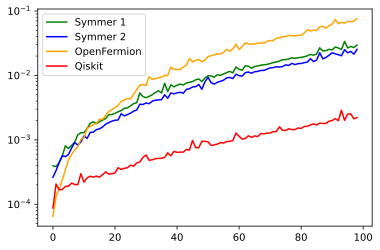

In [159]:
from matplotlib import pyplot as plt

from matplotlib import pyplot as plt

plt.plot(Y_symp, color='green', label='Symmer 1')
plt.plot(Y_para, color='blue', label='Symmer 2')
plt.plot(Y_open, color='orange', label='OpenFermion')
plt.plot(Y_qisk, color='red', label='Qiskit')
plt.yscale('log')

plt.legend()

In [20]:
import multiprocessing as mp
from functools import reduce
from symred.symplectic import PauliwordOp

def multiplication_2(Pword):
    # initiate a pool for parallel processing of Pauli multiplication
    pool = mp.Pool(mp.cpu_count())

    # single Pauli multiplications will output here
    list_of_multiplications = []
    def collect_result(single_mult):
        #global list_of_multiplications
        list_of_multiplications.append(single_mult)

    # loop over the Pauli terms of right-hand PauliwordOp and parallelize
    for term in Pword:
        pool.apply_async(P._multiply_single_Pword, args=(term), callback=collect_result)

    # close the pool and let all the processes complete    
    pool.close()
    pool.join()  # postpones the execution of next line of code until all processes in the queue are done.
    
    symp_out = np.vstack([mult.symp_matrix for mult in list_of_multiplications])
    coef_out = np.hstack([mult.coeff_vec for mult in list_of_multiplications])
        
    return PauliwordOp(symp_out, coef_out).cleanup()

0.0031260251998901367

In [22]:
runtime(multiplication_2, P, n_samples=10)

0.2144090414047241

In [51]:
Y_symp = []
Y_para = []
Y_open = []
Y_qisk = []

n_q = 10

for n_t in range(1, 100):
    print(n_t)
    P = random_PauliwordOp(n_q, n_t)
    P_OF = sum(P.PauliwordOp_to_OF)
    
    Y_symp.append(runtime(lambda x:x*x, P, n_samples=5))
    Y_para.append(runtime(multiplication_2, P, n_samples=5))
    Y_open.append(runtime(lambda x:x*x, P_OF, n_samples=5))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/pool.py", line 581, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/home/tim/anaconda3/lib/python3.7/multiprocessing/pool.py", line 566, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt


75
76
77


KeyboardInterrupt: 

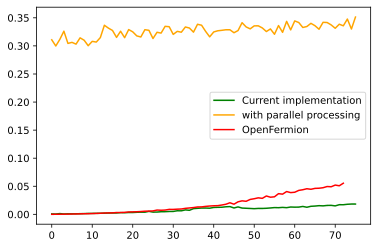

In [63]:
from matplotlib import pyplot as plt

plt.plot(Y_symp, color='green', label='Current implementation')
plt.plot(Y_para, color='orange', label='with parallel processing')
plt.plot(Y_open[:73], color='red', label='OpenFermion')

plt.legend()

In [ ]:
%timeit multiplication_2(P)

In [48]:
P = random_PauliwordOp(3, 2)
P_OF = sum(P.PauliwordOp_to_OF)
print(P*P)
P_OF * P_OF

0.595+0.418j III


(0.5948691680516037+0.41844660603169004j) []

In [144]:
import time

def runtime(func, obj, n_samples=10):
    samples = []
    for sample in range(n_samples):
        start = time.time()
        func(obj)
        stop = time.time()
        samples.append(stop - start)
    return sum(samples)/n_samples

def square(op):
    return op*op
def square_qiskit(op):
    return (op@op).to_pauli_op()

Y_symp=[]
Y_cirq=[]
Y_qisk=[]

for n_terms in range(1,100):
    print(n_terms)
    P = random_PauliwordOp(10, n_terms)
    P_cirq = sum(P.PauliwordOp_to_OF)
    P_qisk = P.to_PauliSumOp
    
    Y_symp.append(runtime(multiplication_1, obj=P))
    Y_cirq.append(runtime(square, obj=P_cirq))
    Y_qisk.append(runtime(square_qiskit, obj=P_qisk))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


KeyboardInterrupt: 

NameError: name 'Y_cirq' is not defined

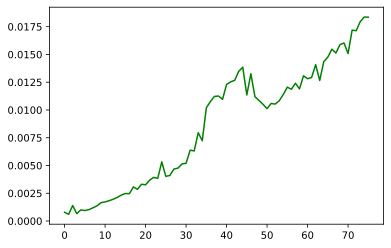

In [52]:
from matplotlib import pyplot as plt

plt.plot(Y_symp, color='green', label='Symplectic')
plt.plot(Y_cirq, color='orange', label='OpenFermion')
plt.plot(Y_qisk, color='red', label='Qiskit')

plt.legend()

In [122]:
P_OF = sum(P.PauliwordOp_to_OF)

%timeit P_OF * P_OF

2.52 s ± 8.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [2]:
def _multiply_single_Pword(self, 
        Pword:"PauliwordOp"
    ) -> "PauliwordOp":
    """ performs Pauli multiplication with phases. The phase compensation 
    is implemented as per https://doi.org/10.1103/PhysRevA.68.042318
    """
    phaseless_prod_Pword = self._multiply_single_Pword_phaseless(Pword)

    # counts ZX mismatches for sign flip
    assert(Pword.n_terms==1), 'not single Pauliword'
    num_sign_flips = np.einsum('ij->i', np.bitwise_and(self.X_block, Pword.Z_block))
    sign_change = (-1) ** num_sign_flips

    # mapping from sigma to tau representation
    full_Y_count = self.Y_count + Pword.Y_count
    sigma_tau_compensation = (-1j) ** full_Y_count

    # back from tau to sigma (note uses output Pword)
    tau_sigma_compensation = (1j) ** phaseless_prod_Pword.Y_count

    # the full phase modification
    phase_mod = sign_change * sigma_tau_compensation * tau_sigma_compensation
    phaseless_prod_Pword.coeff_vec = phase_mod * self.coeff_vec * Pword.coeff_vec

    return phaseless_prod_Pword

In [3]:
from symred.symplectic import random_PauliwordOp

In [63]:
n_q = 5
n_t = 5

P = random_PauliwordOp(n_q, n_t)
Q = random_PauliwordOp(n_q, n_t)

In [78]:
import numpy as np

self = P

def _multiply_single_symplectic(self, Pword):
    assert(Pword.n_terms==1), 'not single Pauliword'
    # updated symp_matrix (Pauli multiplication corresponds with binary addition of symplectic matrices)
    pauli_mult_phaseless = np.bitwise_xor(self.symp_matrix, Pword.symp_matrix)
    
    # counts ZX mismatches for sign flip
    num_sign_flips = np.einsum('ij->i', np.bitwise_and(self.X_block, Pword.Z_block))
    sign_change = (-1) ** num_sign_flips

    # mapping from sigma to tau representation
    full_Y_count = self.Y_count + Pword.Y_count
    sigma_tau_compensation = (-1j) ** full_Y_count

    # back from tau to sigma (note uses output Pword)
    tau_sigma_compensation = (1j) ** phaseless_prod_Pword.Y_count

    # the full phase modification
    phase_mod = sign_change * sigma_tau_compensation * tau_sigma_compensation
    #phaseless_prod_Pword.coeff_vec = phase_mod * self.coeff_vec * Pword.coeff_vec
     
    return pauli_mult_phaseless, phase_mod

_multiply_single_symplectic(self=P, Pword=Q[0])

NameError: name 'phaseless_prod_Pword' is not defined

In [1]:
def mult(P,Q):
    a = np.einsum('ij->i', (P.X_block+Q.X_block)*P.Z_block)
    b = np.einsum('ij->i', (P.Z_block+Q.Z_block)*Q.X_block)
    c = np.einsum('ij->i', np.bitwise_and(
            (np.bitwise_xor(P.X_block, Q.X_block)), np.bitwise_xor(P.Z_block, Q.Z_block))
        )
    # a,b combines the Y counts of P,Q plus a further sign flip
    # c tracks the Y count of the output Paulis
    prod = (1j)**(a+b+3*c)
    
    return PauliwordOp(np.bitwise_xor(P.symp_matrix, Q.symp_matrix), P.coeff_vec*Q.coeff_vec*prod)

%timeit mult(P,Q)

NameError: name 'P' is not defined

In [ ]:
for i in range(100):

    P = random_PauliwordOp(10,1)
    P.coeff_vec = [1]
    Q = random_PauliwordOp(10,1)
    Q.coeff_vec = [1]
    PQ = P*Q

    
    a = (P.X_block+Q.X_block).dot(P.Z_block.T)
    b = (P.Z_block+Q.Z_block).dot(Q.X_block.T)
    c = (np.bitwise_xor(P.X_block, Q.X_block)).dot(np.bitwise_xor(P.Z_block, Q.Z_block).T)
    
    prod= (1j)**(a+b+3*c)
    
    comp = prod[0]
    targ = PQ.coeff_vec
    print(comp, targ, comp == targ)
    print()